# 1: Introduction

Innovative materials design is needed to tackle some of the most important health, environmental, energy, social, and economic challenges of this century. In particular, improving the properties of materials that are intrinsically connected to the generation and utilization of energy is crucial if we are to mitigate environmental damage due to a growing global demand. **Transparent conductors** are an important class of compounds that are both electrically conductive and have a low absorption in the visible range, which are typically competing properties. A combination of both of these characteristics is key for the operation of a variety of technological devices such as photovoltaic cells, light-emitting diodes for flat-panel displays, transistors, sensors, touch screens, and lasers. However, only a small number of compounds are currently known to display both transparency and conductivity suitable enough to be used as transparent conducting materials.

**Aluminum (Al)**, **gallium (Ga)**, **indium (In)** sesquioxides are some of the most promising transparent conductors because of a combination of both **large bandgap energies**, which leads to optical transparency over the visible range, and **high conductivities**. These materials are also chemically stable and relatively inexpensive to produce. Alloying of these binary compounds in ternary or quaternary mixtures could enable the design of a new material at a specific composition with improved properties over what is current possible. These alloys are described by the formula **(AlxGayInz)2NO3N**; where x, y, and z can vary but are limited by the constraint **x+y+z = 1**. The total number of atoms in the unit cell, **N_total=2N+3N**(where N is an integer), is typically between 5 and 100.

However, the main limitation in the design of compounds is that identification and discovery of novel materials for targeted applications requires an examination of enormous compositional and configurational degrees of freedom (i.e., many combinations of x, y, and z). To avoid costly and inefficient trial-and-error of synthetic routes, computational data-driven methods can be used to guide the discovery of potentially more efficient materials to aid in the development of advanced (or totally new) technologies.

In computational material science, the standard tool for computing these properties is the quantum-mechanical method known as **density-functional theory (DFT)**. However, **DFT** calculations are expensive, requiring hundreds or thousands of CPU hours on supercomputers for large systems, which prohibits the modeling of a sizable number of possible compositions and configurations. As a result, potential **(AlxGayInz)2NO3N** materials remain relatively unexplored. Data-driven models offer an alternative approach to efficiently search for new possible compounds in targeted applications but at a significantly reduced computational cost.

This competition aims to accomplish this goal by asking participants to develop or apply data analytics/data mining/machine-learning models for the prediction of two target properties: the **formation energy** (which is an indication of the stability of a new material) and the **bandgap energy** (which is an indication of the potential for transparency over the visible range) to facilitate the discovery of new transparent conductors and allow for advancements in the above-mentioned technologies.

In [1]:
# Importing the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import norm

In [52]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [56]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

In [54]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
# Reading the sample submission
sample = pd.read_csv('sample_submission.csv')
sample.head()

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.1779,1.8892
1,2,0.1779,1.8892
2,3,0.1779,1.8892
3,4,0.1779,1.8892
4,5,0.1779,1.8892


# 2: Exploratory Data Analysis

High-quality data are provided for 3,000 materials that show promise as transparent conductors. The following information has been included:
* Spacegroup (a label identifying the symmetry of the material)
* Total number of Al, Ga, In and O atoms in the unit cell (N_total)
* Relative compositions of Al, Ga, and In (x, y, z)
* Lattice vectors and angles: lv1, lv2, lv3 (which are lengths given in units of angstroms (10^(−10) meters) and α, β, γ (which  are angles in degrees between 0° and 360°)

A domain expert will understand the physical meaning of the above information but those with a data mining background may simply use the data as input for their models.
The task for this competition is to predict two target properties:
* Formation energy (an important indicator of the stability of a material)
* Bandgap energy (an important property for optoelectronic applications)

In [3]:
# Reading the train data without id column
no_id = pd.read_csv('train.csv')
no_id = no_id.drop('id', axis=1)
no_id.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [4]:
# Reading the train data with id column
train_data = pd.read_csv('train.csv')
train_data.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [5]:
train_data.shape

(2400, 14)

In [6]:
train_data.columns

Index(['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'formation_energy_ev_natom',
       'bandgap_energy_ev'],
      dtype='object')

In [7]:
# Variation of data in each column!
train_data.var()

id                            480200.000000
spacegroup                      7176.724147
number_of_total_atoms            510.684851
percent_atom_al                    0.070526
percent_atom_ga                    0.054624
percent_atom_in                    0.069273
lattice_vector_1_ang              31.871183
lattice_vector_2_ang               3.573346
lattice_vector_3_ang              29.710631
lattice_angle_alpha_degree         1.778637
lattice_angle_beta_degree         28.087183
lattice_angle_gamma_degree       669.180113
formation_energy_ev_natom          0.010837
bandgap_energy_ev                  1.013737
dtype: float64

In [8]:
# Mean of data in each column!
train_data.mean()

id                            1200.500000
spacegroup                     141.517917
number_of_total_atoms           61.679167
percent_atom_al                  0.385439
percent_atom_ga                  0.308601
percent_atom_in                  0.305958
lattice_vector_1_ang            10.030005
lattice_vector_2_ang             7.086977
lattice_vector_3_ang            12.593288
lattice_angle_alpha_degree      90.243666
lattice_angle_beta_degree       92.398971
lattice_angle_gamma_degree      94.787600
formation_energy_ev_natom        0.187614
bandgap_energy_ev                2.077205
dtype: float64

In [9]:
# Number of the missing values in each column
train_data.isnull().sum()

id                            0
spacegroup                    0
number_of_total_atoms         0
percent_atom_al               0
percent_atom_ga               0
percent_atom_in               0
lattice_vector_1_ang          0
lattice_vector_2_ang          0
lattice_vector_3_ang          0
lattice_angle_alpha_degree    0
lattice_angle_beta_degree     0
lattice_angle_gamma_degree    0
formation_energy_ev_natom     0
bandgap_energy_ev             0
dtype: int64

In [10]:
# Type of each column
train_data.dtypes

id                              int64
spacegroup                      int64
number_of_total_atoms         float64
percent_atom_al               float64
percent_atom_ga               float64
percent_atom_in               float64
lattice_vector_1_ang          float64
lattice_vector_2_ang          float64
lattice_vector_3_ang          float64
lattice_angle_alpha_degree    float64
lattice_angle_beta_degree     float64
lattice_angle_gamma_degree    float64
formation_energy_ev_natom     float64
bandgap_energy_ev             float64
dtype: object

### 2-1: Individual Feature Analysis

#### spacegroup

In mathematics, physics and chemistry, a **space group** is the symmetry group of a configuration in space, usually in three dimensions. In three dimensions, there are 219 distinct types, or 230 if chiral copies are considered distinct. Space groups are also studied in dimensions other than 3 where they are sometimes called Bieberbach groups, and are discrete cocompact groups of isometries of an oriented Euclidean space.
In **crystallography**, space groups are also called the crystallographic or Fedorov groups, and represent a description of the symmetry of the crystal. A definitive source regarding 3-dimensional space groups is the [International Tables for Crystallography](https://en.wikipedia.org/wiki/Space_group#CITEREFHahn2002).
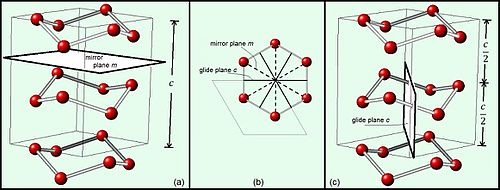

In [11]:
train_data['spacegroup'].unique()

array([ 33, 194, 227, 167, 206,  12], dtype=int64)

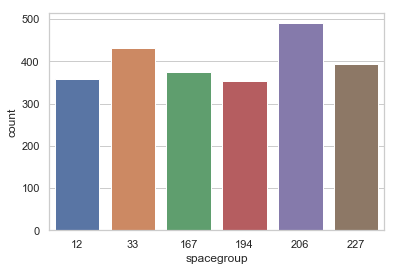

In [12]:
sns.set(style="whitegrid")
sns.countplot(train_data['spacegroup'], data=train_data)

#### number_of_total_atoms

In [13]:
train_data['number_of_total_atoms'].unique()

array([80., 40., 30., 20., 60., 10.])

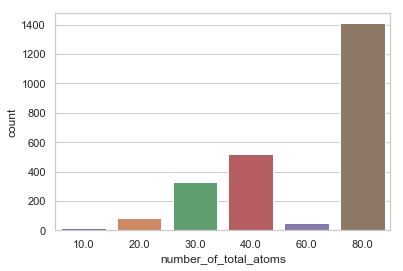

In [14]:
sns.set(style="whitegrid")
sns.countplot(train_data['number_of_total_atoms'], data=train_data)

#### percent_atom of (Al, Ga, In)

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


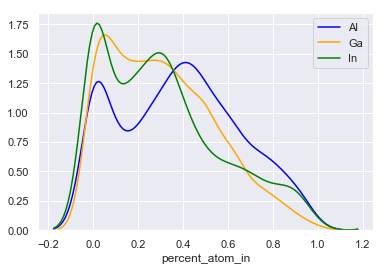

In [15]:
sns.set()
sns.distplot(train_data['percent_atom_al'], hist=False, label='Al', color='blue')
sns.distplot(train_data['percent_atom_ga'], hist=False, label='Ga', color='orange')
sns.distplot(train_data['percent_atom_in'], hist=False, label='In', color='green')

#### lattice_vector_1_ang

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


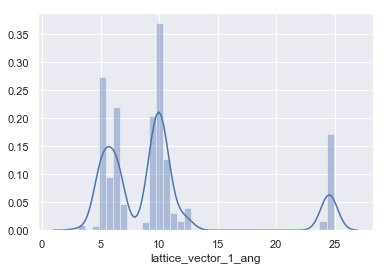

In [16]:
sns.distplot(train_data['lattice_vector_1_ang'])

#### lattice_vector_2_ang

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


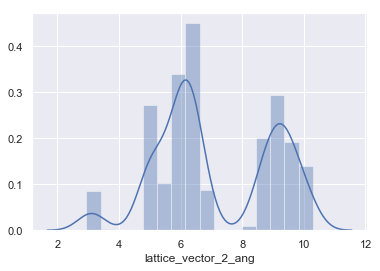

In [17]:
sns.distplot(train_data['lattice_vector_2_ang'])

#### lattice_vector_3_ang

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


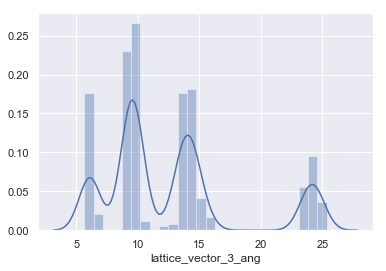

In [18]:
sns.distplot(train_data['lattice_vector_3_ang'])

#### lattice_angle_alpha_degree

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


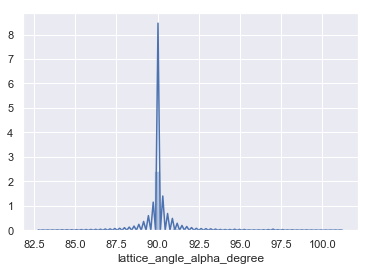

In [19]:
sns.distplot(train_data['lattice_angle_alpha_degree'])

#### lattice_angle_beta_degree

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


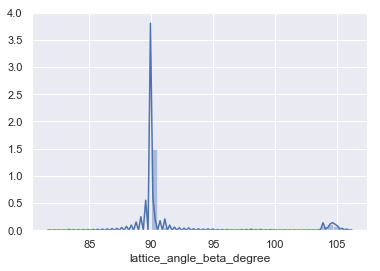

In [20]:
sns.distplot(train_data['lattice_angle_beta_degree'])

#### lattice_angle_gamma_degree

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


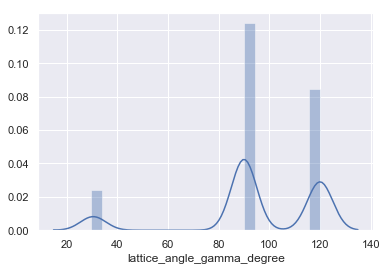

In [21]:
sns.distplot(train_data['lattice_angle_gamma_degree'])

#### formation_energy_ev_natom

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


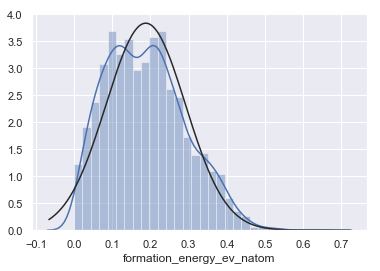

In [22]:
sns.distplot(train_data['formation_energy_ev_natom'], fit=norm)

((array([-3.44194894, -3.19426573, -3.0570759 , ...,  3.0570759 ,
          3.19426573,  3.44194894]),
  array([0.    , 0.    , 0.0007, ..., 0.5369, 0.6121, 0.6572])),
 (0.10298937586772619, 0.18761375000000002, 0.9882702755684459))

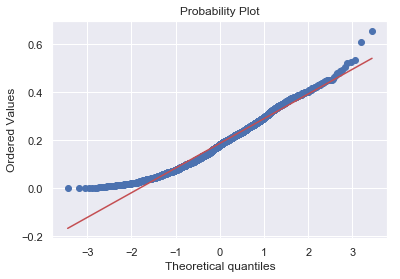

In [23]:
stats.probplot(train_data['formation_energy_ev_natom'], plot=plt)

#### bandgap_energy_ev

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


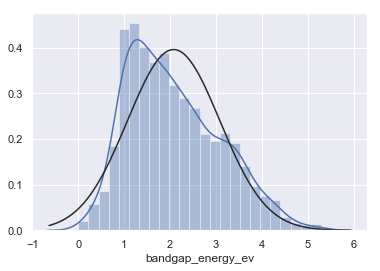

In [24]:
sns.distplot(train_data['bandgap_energy_ev'], fit=norm)

((array([-3.44194894, -3.19426573, -3.0570759 , ...,  3.0570759 ,
          3.19426573,  3.44194894]),
  array([1.0000e-04, 4.9000e-03, 5.7000e-03, ..., 5.2457e+00, 5.2457e+00,
         5.2861e+00])),
 (0.9909187847452391, 2.077205375, 0.9831232271499507))

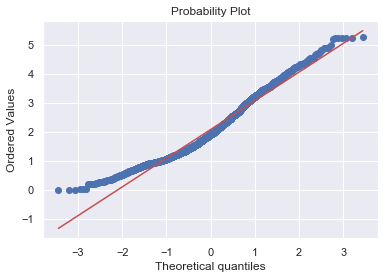

In [25]:
stats.probplot(train_data['bandgap_energy_ev'], plot=plt)

### 2-2: Geometry of the Samples

In [26]:
# gem_1 = open(os.path.join('C:\Users\alisa\AppData\Local\Temp\Temp1_TrainTestData.zip\train.zip\train\1','geometry.xyz'), 'r') 

# 3: Feature Interactions

### 3-1: Correlation of all Features

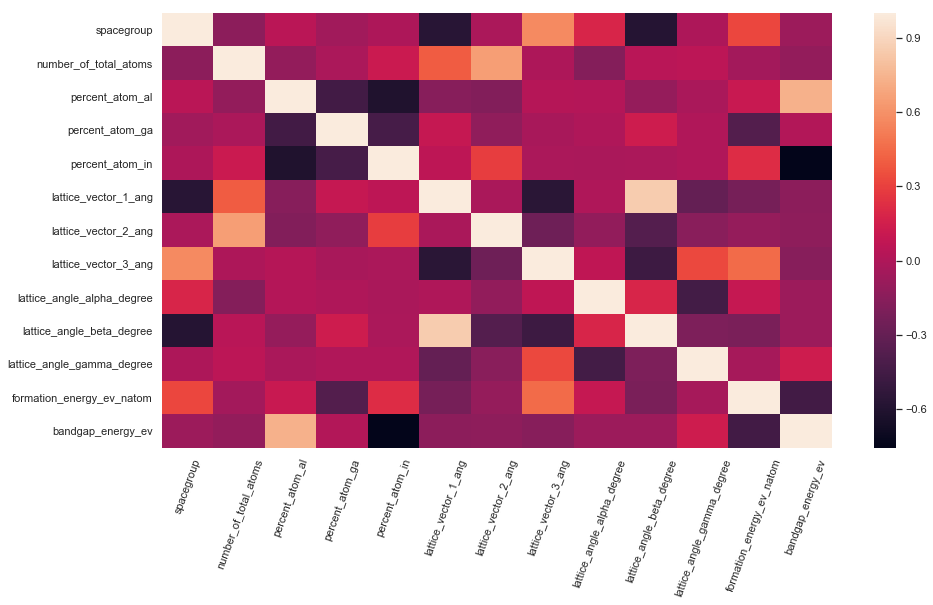

In [27]:
# Here i will use the no_id DataFrame
# Note that the brighter the square, the stronger the features to each other and vise versa!
plt.figure(figsize=(15,8))
heat_map = sns.heatmap(no_id.corr())
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=70);

### 3-2: Piar Plot of the Importatant Features

In [28]:
train_data.columns

Index(['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'formation_energy_ev_natom',
       'bandgap_energy_ev'],
      dtype='object')

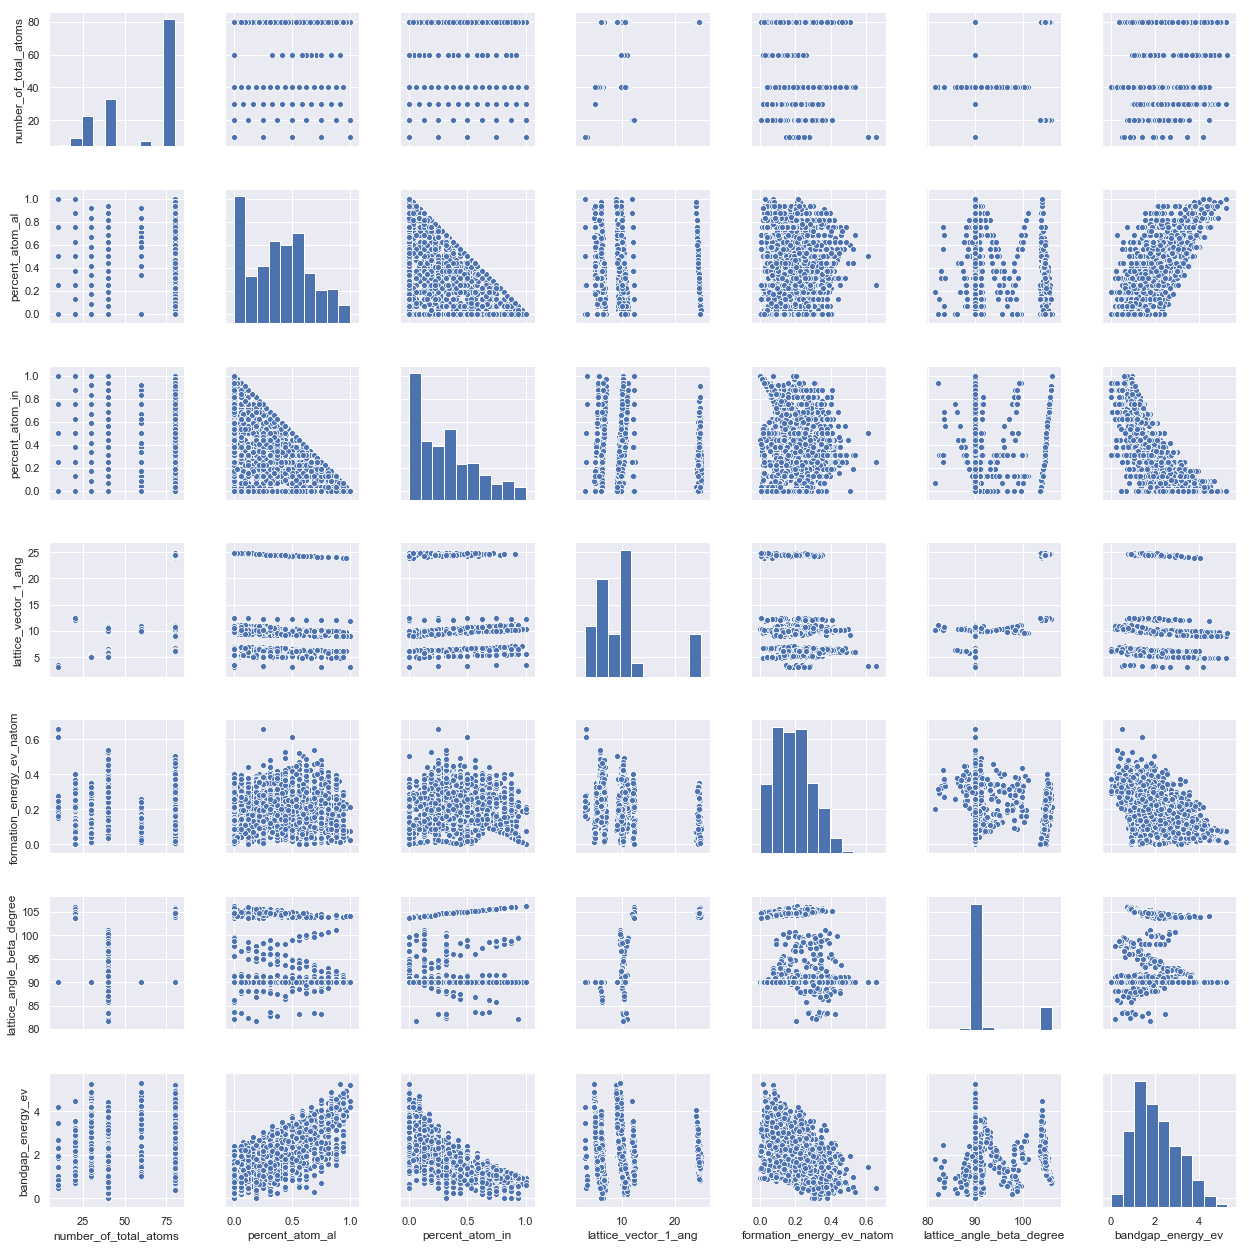

In [29]:
sns.pairplot(train_data[['number_of_total_atoms','percent_atom_al','percent_atom_in','lattice_vector_1_ang',
                         'formation_energy_ev_natom','lattice_angle_beta_degree','bandgap_energy_ev']])

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


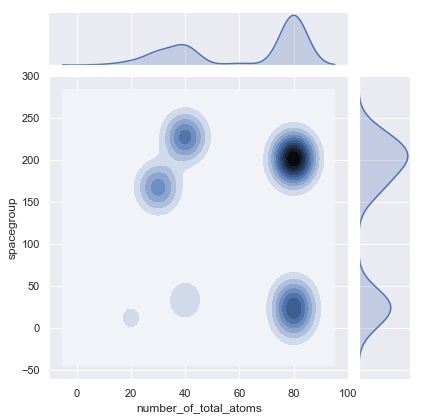

In [30]:
# Space groups vs. Total atoms
sns.jointplot(x='number_of_total_atoms', y='spacegroup', data=train_data, kind='kde')

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


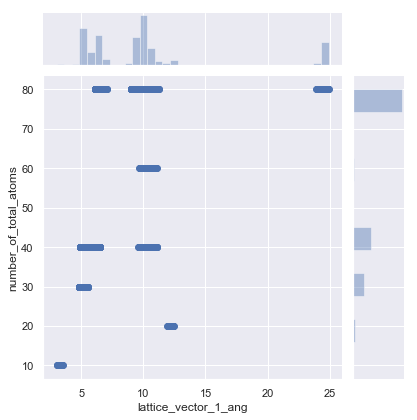

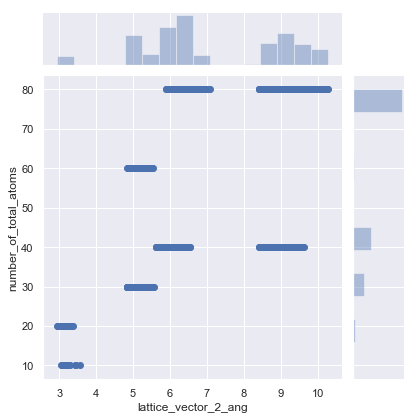

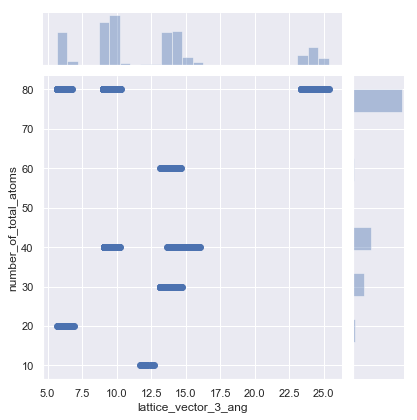

In [31]:
# Lattice vector angles vs. Total atoms
sns.jointplot(x='lattice_vector_1_ang', y='number_of_total_atoms', data=train_data)
sns.jointplot(x='lattice_vector_2_ang', y='number_of_total_atoms', data=train_data)
sns.jointplot(x='lattice_vector_3_ang', y='number_of_total_atoms', data=train_data)

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


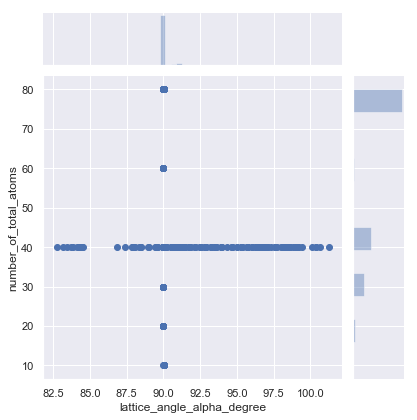

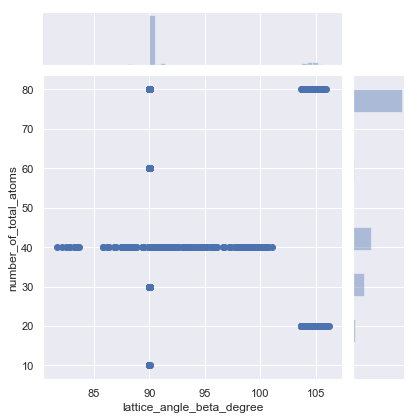

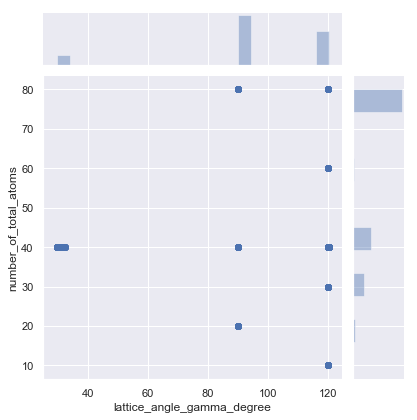

In [32]:
# Lattice angle degrees vs. Total atoms
sns.jointplot(x='lattice_angle_alpha_degree', y='number_of_total_atoms', data=train_data)
sns.jointplot(x='lattice_angle_beta_degree', y='number_of_total_atoms', data=train_data)
sns.jointplot(x='lattice_angle_gamma_degree', y='number_of_total_atoms', data=train_data)

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


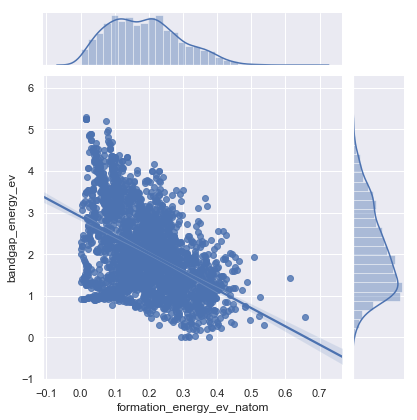

In [55]:
# Bandgap energy vs. Formation energies
sns.jointplot(x='formation_energy_ev_natom', y='bandgap_energy_ev', data=train_data, kind='reg')

### 3-3: Bandgap Energy (ev)

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


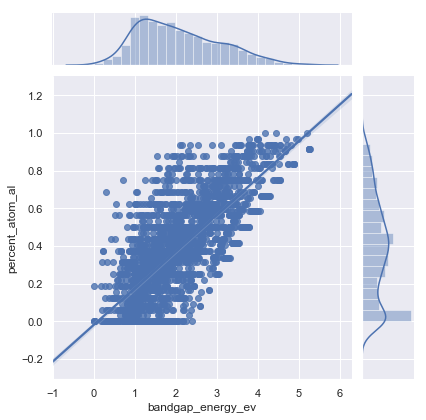

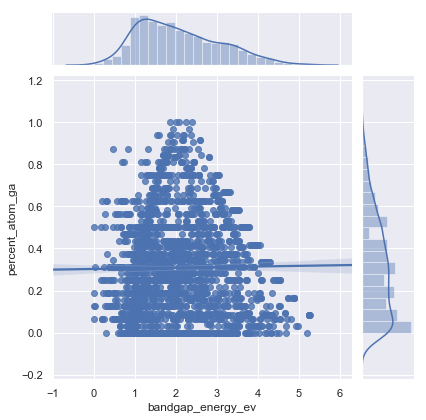

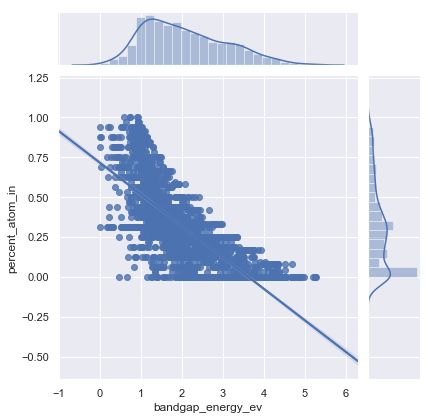

In [33]:
# Badgap energy vs. the percentage of Al, Ga, In
sns.set(color_codes=True)
sns.jointplot(x='bandgap_energy_ev', y='percent_atom_al', data=train_data, kind="reg")
sns.jointplot(x='bandgap_energy_ev', y='percent_atom_ga', data=train_data, kind="reg")
sns.jointplot(x='bandgap_energy_ev', y='percent_atom_in', data=train_data, kind="reg")

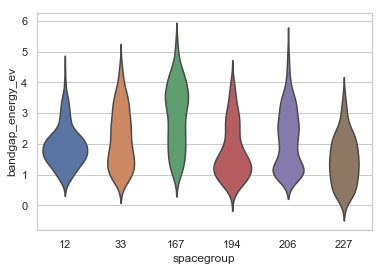

In [34]:
# Badgap energy vs. space group
sns.set(style="whitegrid")
sns.violinplot(x=train_data['spacegroup'], y=train_data['bandgap_energy_ev'], data=train_data, inner=None)

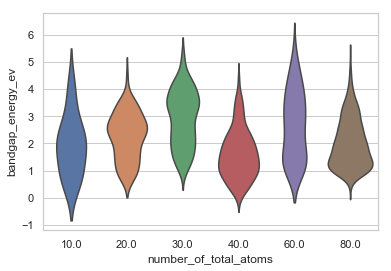

In [35]:
# Badgap energy vs. number of total atoms
sns.set(style="whitegrid")
sns.violinplot(x=train_data['number_of_total_atoms'], y=train_data['bandgap_energy_ev'], data=train_data, inner=None)

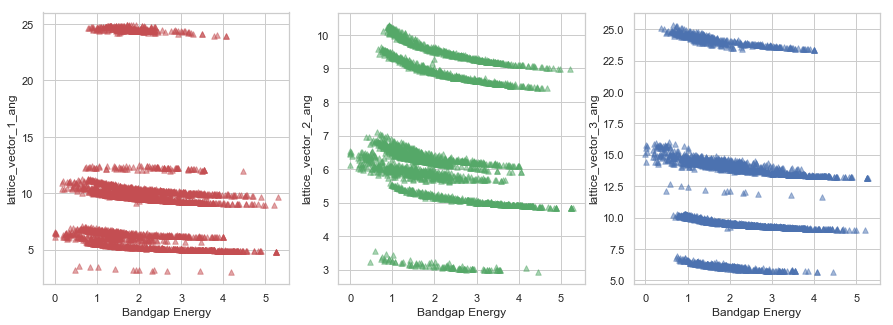

In [36]:
# Badgap energy vs. the lattice vector angles
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.scatter(train_data['bandgap_energy_ev'], train_data['lattice_vector_1_ang'], c='r', alpha=0.5, s=30, marker='^')
plt.xlabel('Bandgap Energy')
plt.ylabel('lattice_vector_1_ang')

plt.subplot(1, 3, 2)
plt.scatter(train_data['bandgap_energy_ev'], train_data['lattice_vector_2_ang'], c='g', alpha=0.5, s=30, marker='^')
plt.xlabel('Bandgap Energy')
plt.ylabel('lattice_vector_2_ang')

plt.subplot(1, 3, 3)
plt.scatter(train_data['bandgap_energy_ev'], train_data['lattice_vector_3_ang'], c='b', alpha=0.5, s=30, marker='^')
plt.xlabel('Bandgap Energy')
plt.ylabel('lattice_vector_3_ang')

plt.show()

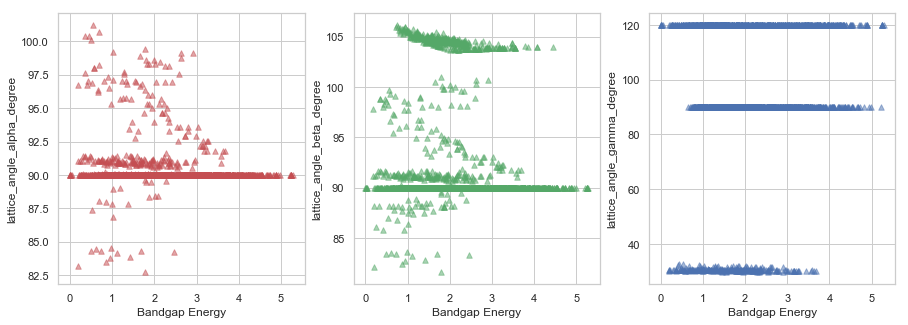

In [37]:
# Badgap energy vs. the lattice angle degree
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.scatter(train_data['bandgap_energy_ev'], train_data['lattice_angle_alpha_degree'], c='r', alpha=0.5, s=30, marker='^')
plt.xlabel('Bandgap Energy')
plt.ylabel('lattice_angle_alpha_degree')

plt.subplot(1, 3, 2)
plt.scatter(train_data['bandgap_energy_ev'], train_data['lattice_angle_beta_degree'], c='g', alpha=0.5, s=30, marker='^')
plt.xlabel('Bandgap Energy')
plt.ylabel('lattice_angle_beta_degree')

plt.subplot(1, 3, 3)
plt.scatter(train_data['bandgap_energy_ev'], train_data['lattice_angle_gamma_degree'], c='b', alpha=0.5, s=30, marker='^')
plt.xlabel('Bandgap Energy')
plt.ylabel('lattice_angle_gamma_degree')

plt.show()

### 3-4: Formation Energy (ev)

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


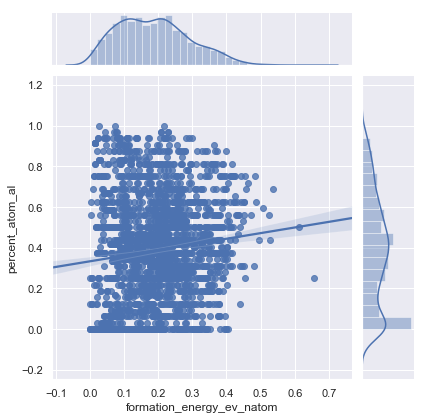

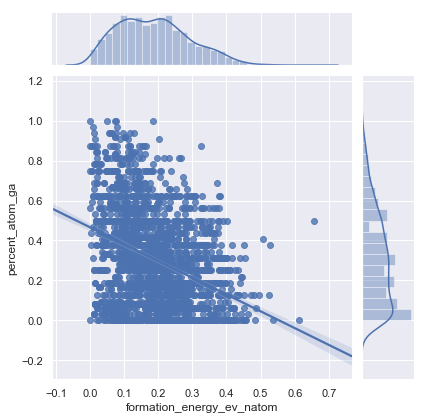

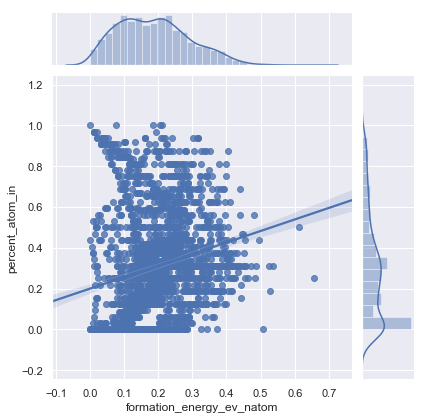

In [38]:
# Formation energy vs. the percentage of Al, Ga, In
sns.set(color_codes=True)
sns.jointplot(x='formation_energy_ev_natom', y='percent_atom_al', data=train_data, kind="reg")
sns.jointplot(x='formation_energy_ev_natom', y='percent_atom_ga', data=train_data, kind="reg")
sns.jointplot(x='formation_energy_ev_natom', y='percent_atom_in', data=train_data, kind="reg")

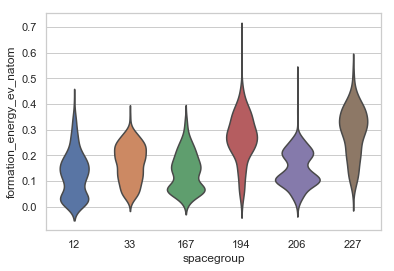

In [39]:
# Formation energy vs. space group
sns.set(style="whitegrid")
sns.violinplot(x=train_data['spacegroup'], y=train_data['formation_energy_ev_natom'], data=train_data, inner=None)

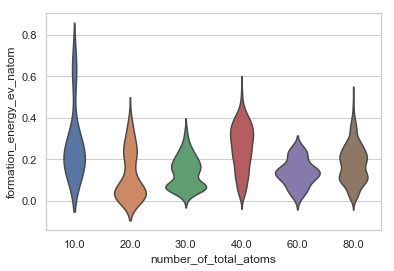

In [40]:
# Formation energy vs. number of total atoms
sns.set(style="whitegrid")
sns.violinplot(x=train_data['number_of_total_atoms'], y=train_data['formation_energy_ev_natom'], data=train_data, inner=None)

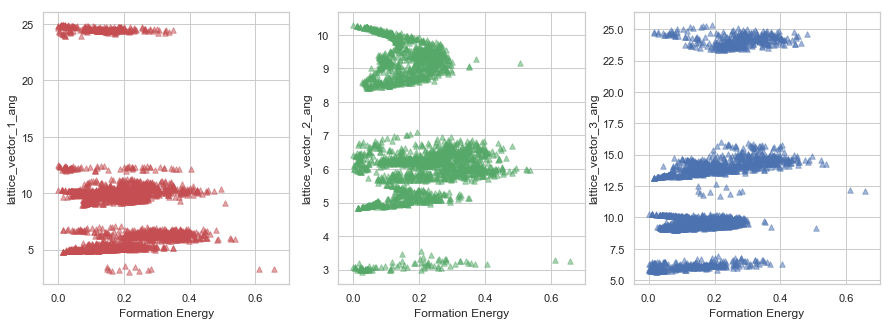

In [41]:
# Formation energy vs. the lattice vector angles
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.scatter(train_data['formation_energy_ev_natom'], train_data['lattice_vector_1_ang'], c='r', alpha=0.5, s=30, marker='^')
plt.xlabel('Formation Energy')
plt.ylabel('lattice_vector_1_ang')

plt.subplot(1, 3, 2)
plt.scatter(train_data['formation_energy_ev_natom'], train_data['lattice_vector_2_ang'], c='g', alpha=0.5, s=30, marker='^')
plt.xlabel('Formation Energy')
plt.ylabel('lattice_vector_2_ang')

plt.subplot(1, 3, 3)
plt.scatter(train_data['formation_energy_ev_natom'], train_data['lattice_vector_3_ang'], c='b', alpha=0.5, s=30, marker='^')
plt.xlabel('Formation Energy')
plt.ylabel('lattice_vector_3_ang')

plt.show()

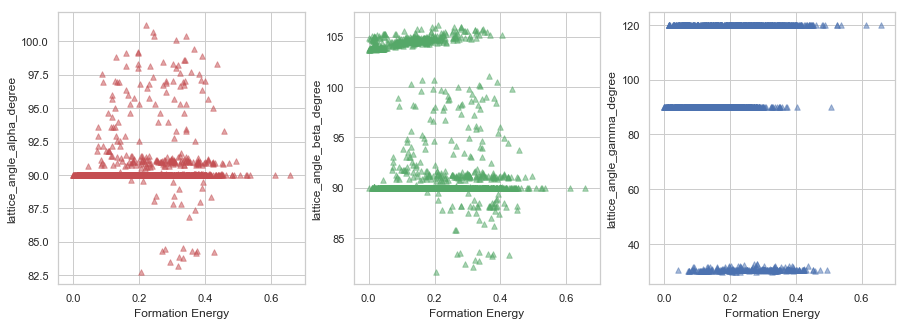

In [42]:
# Formation energy vs. the lattice angle degree
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.scatter(train_data['formation_energy_ev_natom'], train_data['lattice_angle_alpha_degree'], c='r', alpha=0.5, s=30, marker='^')
plt.xlabel('Formation Energy')
plt.ylabel('lattice_angle_alpha_degree')

plt.subplot(1, 3, 2)
plt.scatter(train_data['formation_energy_ev_natom'], train_data['lattice_angle_beta_degree'], c='g', alpha=0.5, s=30, marker='^')
plt.xlabel('Formation Energy')
plt.ylabel('lattice_angle_beta_degree')

plt.subplot(1, 3, 3)
plt.scatter(train_data['formation_energy_ev_natom'], train_data['lattice_angle_gamma_degree'], c='b', alpha=0.5, s=30, marker='^')
plt.xlabel('Formation Energy')
plt.ylabel('lattice_angle_gamma_degree')

plt.show()

### 3-5: Multi-Feature Interactions

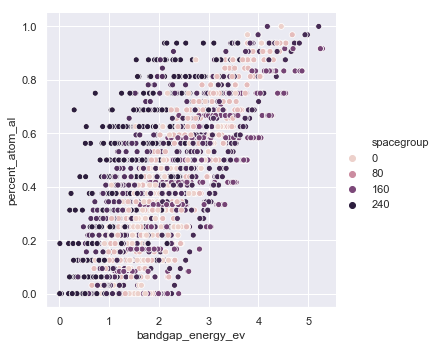

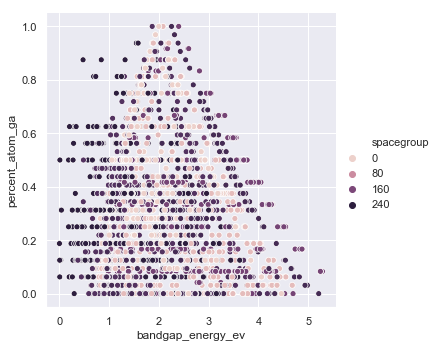

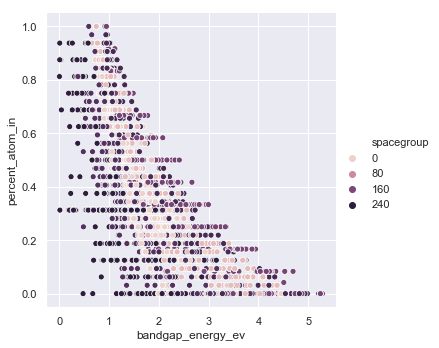

In [43]:
# Badgap energy vs. the percentage of Al, Ga, In on Space group
sns.set(color_codes=True)
sns.relplot(x='bandgap_energy_ev', y='percent_atom_al', hue='spacegroup', data=train_data, kind='scatter')
sns.relplot(x='bandgap_energy_ev', y='percent_atom_ga', hue='spacegroup', data=train_data, kind='scatter')
sns.relplot(x='bandgap_energy_ev', y='percent_atom_in', hue='spacegroup', data=train_data, kind='scatter')

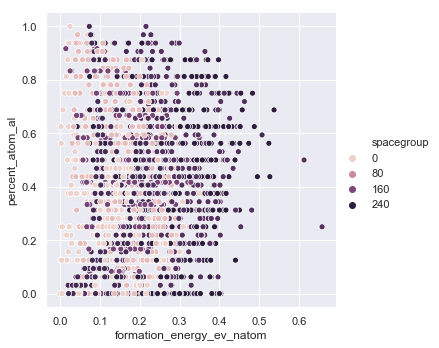

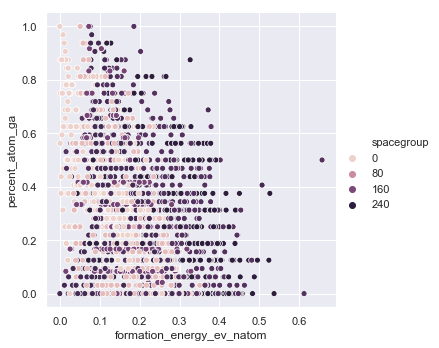

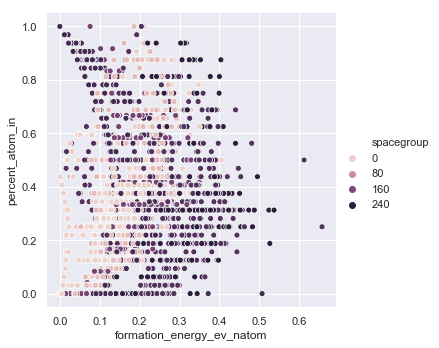

In [44]:
# Formation energy vs. the percentage of Al, Ga, In on Space group
sns.relplot(x='formation_energy_ev_natom', y='percent_atom_al', hue='spacegroup', data=train_data, kind='scatter')
sns.relplot(x='formation_energy_ev_natom', y='percent_atom_ga', hue='spacegroup', data=train_data, kind='scatter')
sns.relplot(x='formation_energy_ev_natom', y='percent_atom_in', hue='spacegroup', data=train_data, kind='scatter')

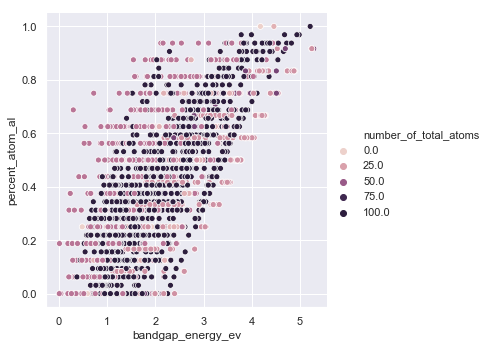

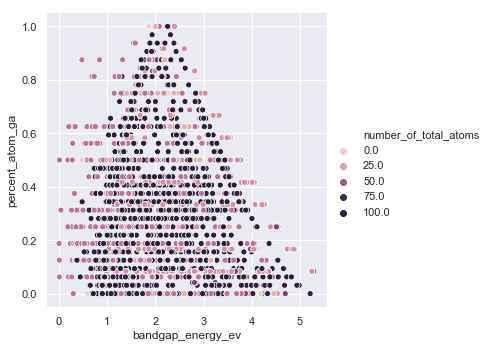

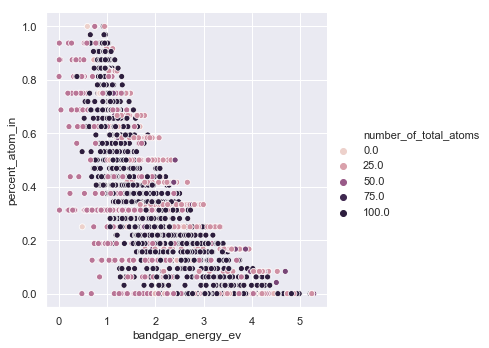

In [45]:
# Badgap energy vs. the percentage of Al, Ga, In on Total Atoms
sns.set(color_codes=True)
sns.relplot(x='bandgap_energy_ev', y='percent_atom_al', hue='number_of_total_atoms', data=train_data, kind='scatter')
sns.relplot(x='bandgap_energy_ev', y='percent_atom_ga', hue='number_of_total_atoms', data=train_data, kind='scatter')
sns.relplot(x='bandgap_energy_ev', y='percent_atom_in', hue='number_of_total_atoms', data=train_data, kind='scatter')

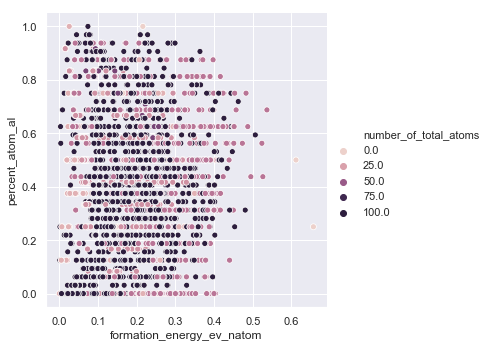

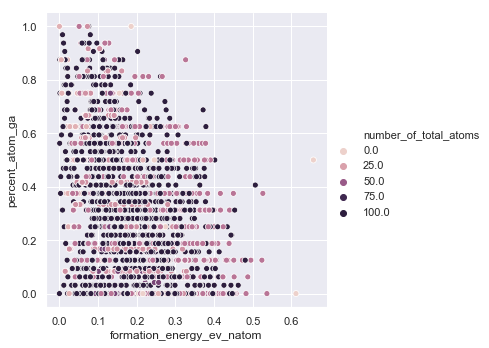

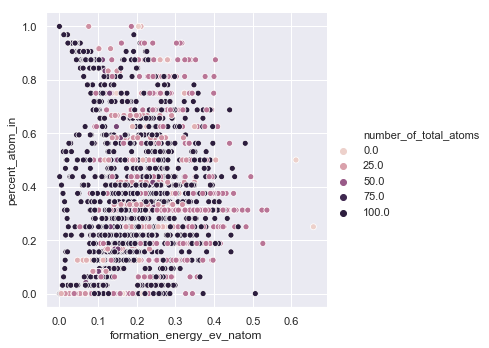

In [46]:
# Formation energy vs. the percentage of Al, Ga, In on Total Atoms
sns.relplot(x='formation_energy_ev_natom', y='percent_atom_al', hue='number_of_total_atoms', data=train_data, kind='scatter')
sns.relplot(x='formation_energy_ev_natom', y='percent_atom_ga', hue='number_of_total_atoms', data=train_data, kind='scatter')
sns.relplot(x='formation_energy_ev_natom', y='percent_atom_in', hue='number_of_total_atoms', data=train_data, kind='scatter')

# 4: Standardizing Data

In [65]:
# Features
df_features = train_data.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'], axis=1)
df_features.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893


In [66]:
# Targets
df_targets = train_data[['formation_energy_ev_natom','bandgap_energy_ev']]
df_targets.head()

,formation_energy_ev_natom,bandgap_energy_ev
0,0.0680,3.4387
1,0.2490,2.9210
2,0.1821,2.7438
3,0.2172,3.3492
4,0.0505,1.3793


### 4-1: Log-Normalization

In [59]:
# ??

### 4-2: Scaling

In [73]:
# Before scaling
df_features.var()

spacegroup                    7176.724147
number_of_total_atoms          510.684851
percent_atom_al                  0.070526
percent_atom_ga                  0.054624
percent_atom_in                  0.069273
lattice_vector_1_ang            31.871183
lattice_vector_2_ang             3.573346
lattice_vector_3_ang            29.710631
lattice_angle_alpha_degree       1.778637
lattice_angle_beta_degree       28.087183
lattice_angle_gamma_degree     669.180113
dtype: float64

In [74]:
# After scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
df_scaled.var()

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


spacegroup                    1.000417
number_of_total_atoms         1.000417
percent_atom_al               1.000417
percent_atom_ga               1.000417
percent_atom_in               1.000417
lattice_vector_1_ang          1.000417
lattice_vector_2_ang          1.000417
lattice_vector_3_ang          1.000417
lattice_angle_alpha_degree    1.000417
lattice_angle_beta_degree     1.000417
lattice_angle_gamma_degree    1.000417
dtype: float64

# 5: Feature Engineering

In [48]:
# Create new features based on existing features!

# 6: Feature Selection

In [49]:
# Selecting features to work with

# 7: Dimentionality Reduction

In [50]:
# PCA...

# 8: Prediction with Machine Learning Methods

In [78]:
train_X = df_scaled.values
train_y = df_targets.values

### 8-1: train_test_split()

In [79]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.33, random_state=1)
print('Numbers of train data is: ', len(X_train), '\nNumbers of test data is: ', len(X_test))

Numbers of train data is:  1608 
Numbers of test data is:  792


#### MultiOutputRegressor()

In [83]:
# Create model
max_depth = 30
reg_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=0))

In [84]:
# Fit model
%time reg_multirf.fit(X_train, y_train)

Wall time: 2.15 s


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
           n_jobs=None)

In [86]:
# Predict on test data
pred_multirf = reg_multirf.predict(X_test)
reg_multirf.score(X_test, y_test)

0.8926929974173161

#### RandomForestRegressor()

In [87]:
# Create model
max_depth = 30
reg_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)

In [88]:
# Fit model
%time reg_rf.fit(X_train, y_train)

Wall time: 1.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [89]:
# Predict on test data
pred_rf = reg_rf.predict(X_test)
reg_rf.score(X_test, y_test)

0.949219419814475

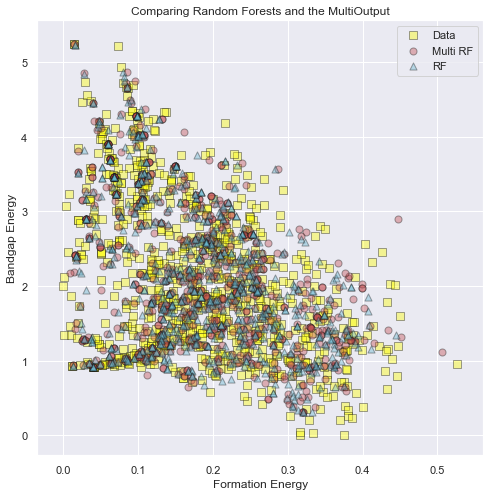

In [93]:
# Plotting both graphs with each other
plt.figure(figsize=(8,8))
plt.scatter(y_test[:,0], y_test[:,1], edgecolor='k', c="yellow", s=50, marker="s", alpha=0.4, label="Data")
plt.scatter(pred_multirf[:,0], pred_multirf[:,1], edgecolor='k', c="r", s=50, marker="o", alpha=0.4, label="Multi RF")
plt.scatter(pred_rf[:,0], pred_rf[:,1], edgecolor='k', c="c", s=50, marker="^", alpha=0.4, label="RF")
plt.xlabel("Formation Energy")
plt.ylabel("Bandgap Energy")
plt.title("Comparing Random Forests and the MultiOutput")
plt.legend()
plt.show()